<a href="https://colab.research.google.com/github/Jbarrera2000/Natural-language-processing-Tensorflow/blob/main/PORFTOLIO_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-97ceee3b-6397-074d-bdef-2740b53c384a)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 6.35 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

##Preprocessing data

In [ ]:
#Preprocess - take the text file as a complete sting and separate it in strings by line
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id= line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["line_number"] = abstract_line_number
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["total_lines"]=len(abstract_line_split)-1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line

  return abstract_samples 

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 667 ms, sys: 109 ms, total: 776 ms
Wall time: 1.49 s


(180040, 30212, 30135)

In [ ]:
train_samples[:2]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11}]

In [ ]:
import pandas as pd 
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(2)

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

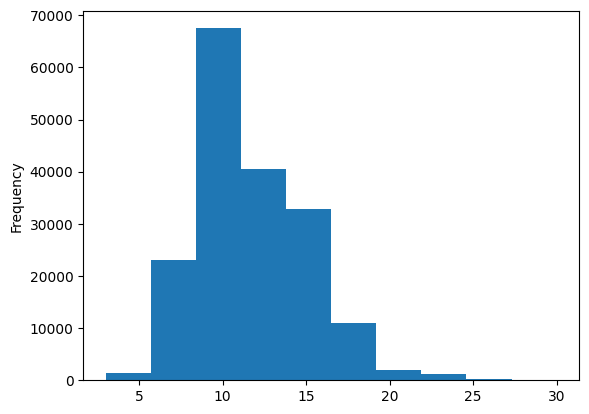

In [ ]:
train_df.total_lines.plot.hist(); #most of the abstracts's size is 7 to 15 sentences in length

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
train_sentences[:2]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .']

##Scikit-Learn

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

##Building Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
#72.18% Accuracy
model_0.score(X=val_sentences, 
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
preds_0 = model_0.predict(val_sentences)
preds_0

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
model_0_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=preds_0)
model_0_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

##  Vectorization and Embedding layers

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
#Average long of each sentence
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

In [ ]:
#95% of the sentences have 55 tokens
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=68000,
                                    output_sequence_length=55)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
additional alfaxalone boli were administered iv if cats moved/swallowed ( @ mgkg ( -@ ) ) or if fr > @ breaths minute ( -@ ) ( @ mgkg ( -@ ) ) .

Length of text: 34

Vectorized text:
[[  365  7120 32377     9   336   651   324  2980 51953   618    16   324
   4115 11283   929   618     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()

In [ ]:
#Text Vectorizer properties
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#Embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
additional alfaxalone boli were administered iv if cats moved/swallowed ( @ mgkg ( -@ ) ) or if fr > @ breaths minute ( -@ ) ( @ mgkg ( -@ ) ) .

Sentence after vectorization (before embedding):
[[  365  7120 32377     9   336   651   324  2980 51953   618    16   324
   4115 11283   929   618     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02533661 -0.04834364  0.00204986 ... -0.00486586 -0.04090083
   -0.0261206 ]
  [-0.02152233  0.02550885 -0.02682458 ... -0.00682323 -0.00947627
    0.01316041]
  [ 0.00020606  0.04491666 -0.0344813  ...  0.01570494  0.01138955
   -0.03688078]
  ...
  [-0.02879852 -0.03329214 -0.02959239 ...  0.02497593  0.02779566
   -0.03759671]
  [-0.02879852 -0.03329214 -0.02959239 ...  0.02497593  0.02779566


##PrefetchDataset of batches - faster

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

##model_1

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 67s 100ms/step - loss: 0.9222 - accuracy: 0.6347 - val_loss: 0.6845 - val_accuracy: 0.7384
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 0.6540 - accuracy: 0.7579 - val_loss: 0.6316 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 10s 17ms/step - loss: 0.6147 - accuracy: 0.7746 - val_loss: 0.5950 - val_accuracy: 0.7842


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5954 - accuracy: 0.7867


[0.5953836441040039, 0.7866741418838501]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[4.22308177e-01, 1.28051788e-01, 7.54274055e-02, 3.51242870e-01,
        2.29697619e-02],
       [4.23403591e-01, 2.77633011e-01, 1.66164506e-02, 2.69916177e-01,
        1.24308495e-02],
       [1.41174659e-01, 6.81677833e-03, 1.42736686e-03, 8.50552380e-01,
        2.87927960e-05],
       ...,
       [7.22058121e-06, 5.55178733e-04, 7.97982386e-04, 6.97418182e-06,
        9.98632610e-01],
       [5.72571643e-02, 5.07080078e-01, 8.15381706e-02, 6.81847259e-02,
        2.85939902e-01],
       [1.53280929e-01, 7.10895002e-01, 3.93526666e-02, 3.92625146e-02,
        5.72088920e-02]], dtype=float32)

In [ ]:
# probabilities to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_1_preds)

model_1_results

{'accuracy': 78.66741692042896,
 'precision': 0.7837046897089346,
 'recall': 0.7866741692042897,
 'f1': 0.7841512218610243}

##model_2

In [ ]:
#Pretrained encoder - FE Tranfer Learning 
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence: {random_training_sentence}\n")
embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding: {embedded_sentence[0][:30]}")
print(f"Length sentence {len(random_training_sentence)}, Lenght embedded sentence: {len(embedded_sentence[0])}")

Random training sentence: no statistically significant difference was determined between the groups in terms of age ( p = @ ) , sex ( p = @ ) , reduction success ( p = @ ) , and patient-physician satisfaction ( p = @ ) .

Sentence after embedding: [ 0.03142085 -0.08204951 -0.00755965 -0.00030219 -0.00950238  0.03413819
  0.00314754 -0.05675208  0.0477645   0.05089428  0.01082158  0.04996911
 -0.04725369 -0.0123437   0.05687085 -0.06785278 -0.03673068  0.00095394
 -0.03044093 -0.06201269  0.03063515  0.02518294 -0.0037442  -0.06154083
  0.06500668  0.06821096  0.02493902  0.02698798  0.0180652  -0.03118234]
Length sentence 194, Lenght embedded sentence: 512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2=tf.keras.Model(inputs, outputs)

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps= int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 22ms/step - loss: 0.9202 - accuracy: 0.6447 - val_loss: 0.7988 - val_accuracy: 0.6895
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7702 - accuracy: 0.7005 - val_loss: 0.7561 - val_accuracy: 0.7074
Epoch 3/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7535 - accuracy: 0.7114 - val_loss: 0.7408 - val_accuracy: 0.7154


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.7422 - accuracy: 0.7127


[0.7422077059745789, 0.7126638293266296]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 15s 15ms/step


array([[0.45222273, 0.30204046, 0.00287515, 0.23490213, 0.00795945],
       [0.32695344, 0.5066877 , 0.00386159, 0.1592691 , 0.0032282 ],
       [0.23270153, 0.18145996, 0.02312141, 0.5181678 , 0.04454931],
       ...,
       [0.00177866, 0.00640885, 0.05324709, 0.00101742, 0.9375479 ],
       [0.00377752, 0.05008338, 0.20179103, 0.00137777, 0.7429702 ],
       [0.15561518, 0.2408881 , 0.5351949 , 0.00430881, 0.06399301]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.26638421819145,
 'precision': 0.7131110736613259,
 'recall': 0.7126638421819145,
 'f1': 0.7095167082587995}

##model_3

In [ ]:
#Character embedding
def split_chars(text):
  return " ".join(list(text))

split_chars(random_training_sentence)

'n o   s t a t i s t i c a l l y   s i g n i f i c a n t   d i f f e r e n c e   w a s   d e t e r m i n e d   b e t w e e n   t h e   g r o u p s   i n   t e r m s   o f   a g e   (   p   =   @   )   ,   s e x   (   p   =   @   )   ,   r e d u c t i o n   s u c c e s s   (   p   =   @   )   ,   a n d   p a t i e n t - p h y s i c i a n   s a t i s f a c t i o n   (   p   =   @   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
majority_char_len = int(np.percentile(char_lens, 95))
majority_char_len

290

In [ ]:
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
from keras.layers.serialization import text_vectorization
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=majority_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   l o n g   h a l f - l i f e   o f   a t o r v a s t a t i n   a n d   f e n o f i b r a t e   m a k e s   t h e m   s u i t a b l e   f o r   a l t e r n a t e   d a y   t h e r a p y   .

Length of chars: 84

Vectorized chars:
[[ 3 13  2 12  7  6 18 13  5 12 17 12  4 17  2  7 17  5  3  7  8 21  5  9
   3  5  3  4  6  5  6 10 17  2  6  7 17  4 22  8  5  3  2 15  5 23  2  9
   3 13  2 15  9 16  4  3  5 22 12  2 17  7  8  5 12  3  2  8  6  5  3  2
  10  5 19  3 13  2  8  5 14 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0 

In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS,
                              output_dim=25,
                              mask_zero=False,
                              name="char_embed")

In [ ]:
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t h e   l o n g   h a l f - l i f e   o f   a t o r v a s t a t i n   a n d   f e n o f i b r a t e   m a k e s   t h e m   s u i t a b l e   f o r   a l t e r n a t e   d a y   t h e r a p y   .

Embedded chars (after vectorization and embedding):
[[[-0.01992526  0.0464126  -0.0036406  ...  0.03457579 -0.03509421
    0.04026439]
  [-0.00451048  0.0261138  -0.00594958 ...  0.02505985 -0.03226312
    0.03379244]
  [ 0.03109005  0.0417199  -0.0496161  ... -0.01639225  0.03073863
    0.02922083]
  ...
  [-0.02951146  0.02922102  0.02317918 ...  0.0217354   0.00063083
   -0.01465204]
  [-0.02951146  0.02922102  0.02317918 ...  0.0217354   0.00063083
   -0.01465204]
  [-0.02951146  0.02922102  0.02317918 ...  0.0217354   0.00063083
   -0.01465204]]]

Character embedding shape: (1, 290, 25)


In [ ]:
inputs=layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer= tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
#PrefetchedDatasets - (char-level)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 10ms/step - loss: 1.2635 - accuracy: 0.4796 - val_loss: 1.0574 - val_accuracy: 0.5635
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 1.0074 - accuracy: 0.5958 - val_loss: 0.9361 - val_accuracy: 0.6287
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.9250 - accuracy: 0.6338 - val_loss: 0.8594 - val_accuracy: 0.6656


In [ ]:
model_3.evaluate(val_char_dataset)


945/945 [==============================] - 3s 4ms/step - loss: 0.8828 - accuracy: 0.6566


[0.8828238844871521, 0.656593382358551]

In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[0.25940886, 0.26572025, 0.12778907, 0.27316317, 0.07391863],
       [0.16928203, 0.64340806, 0.02338174, 0.1271494 , 0.03677874],
       [0.23268987, 0.20149353, 0.33860314, 0.15936555, 0.06784789],
       ...,
       [0.00687233, 0.02678336, 0.12136023, 0.02112174, 0.8238623 ],
       [0.02213702, 0.11535591, 0.47893524, 0.01480987, 0.36876193],
       [0.5875085 , 0.298958  , 0.04180911, 0.06150428, 0.01022012]],
      dtype=float32)

In [ ]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 2, ..., 4, 2, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.65934065934066,
 'precision': 0.6486659534717867,
 'recall': 0.6565934065934066,
 'f1': 0.6447998435163957}

In [ ]:
pe=[0]

##model_4

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs= token_output)


In [ ]:
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

In [ ]:
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

In [ ]:
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

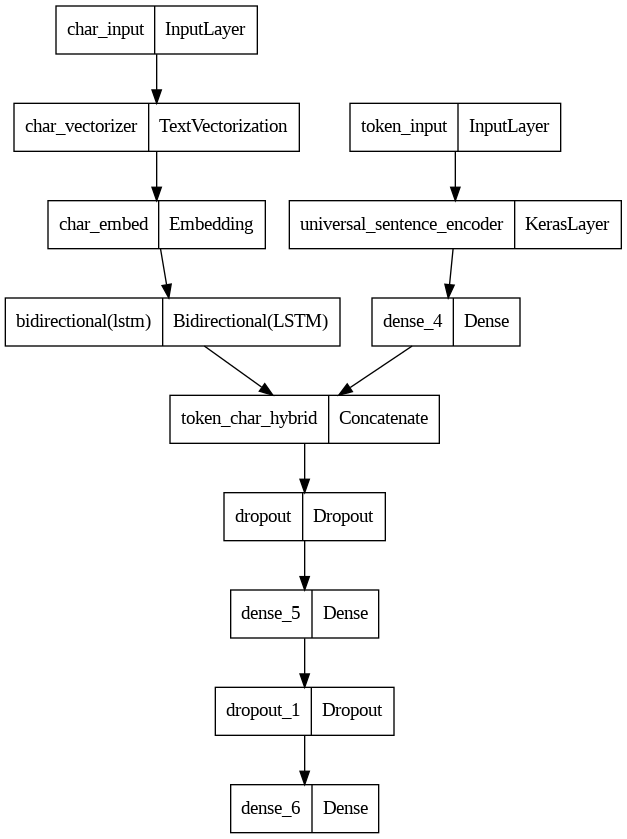

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset , val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 37s 54ms/step - loss: 0.9706 - accuracy: 0.6150 - val_loss: 0.7738 - val_accuracy: 0.7055
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7936 - accuracy: 0.6912 - val_loss: 0.7170 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 32s 57ms/step - loss: 0.7707 - accuracy: 0.7055 - val_loss: 0.6989 - val_accuracy: 0.7407


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 33s 35ms/step - loss: 0.6996 - accuracy: 0.7322


[0.6996225118637085, 0.7321925163269043]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 24s 23ms/step


array([[4.4221482e-01, 3.4245393e-01, 4.3868516e-03, 2.0242974e-01,
        8.5146669e-03],
       [3.4308264e-01, 4.8371306e-01, 2.6539308e-03, 1.6852146e-01,
        2.0289707e-03],
       [2.5848684e-01, 1.1470049e-01, 4.2851482e-02, 5.4943579e-01,
        3.4525327e-02],
       ...,
       [5.3543196e-04, 6.9684177e-03, 4.3588825e-02, 3.4531468e-04,
        9.4856197e-01],
       [9.0559218e-03, 6.6276692e-02, 1.6426961e-01, 4.8691398e-03,
        7.5552863e-01],
       [1.9837084e-01, 5.4043579e-01, 1.8778323e-01, 2.4155963e-02,
        4.9254142e-02]], dtype=float32)

In [ ]:
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.21925062888918,
 'precision': 0.7358941801238331,
 'recall': 0.7321925062888919,
 'f1': 0.73027380131635}

##model_5

In [ ]:
train_df.head() #positional embedding

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

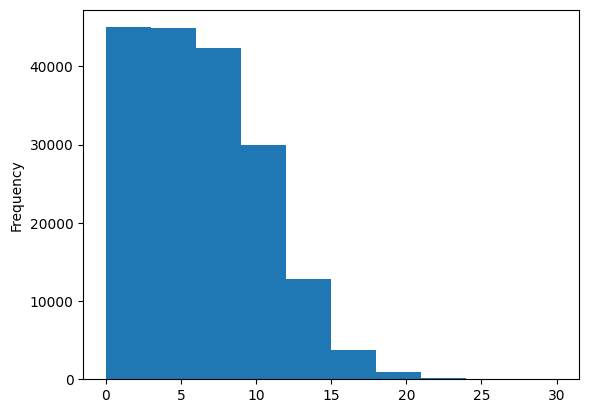

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot.shape , train_line_numbers_one_hot[:20]

(TensorShape([180040, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0.

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

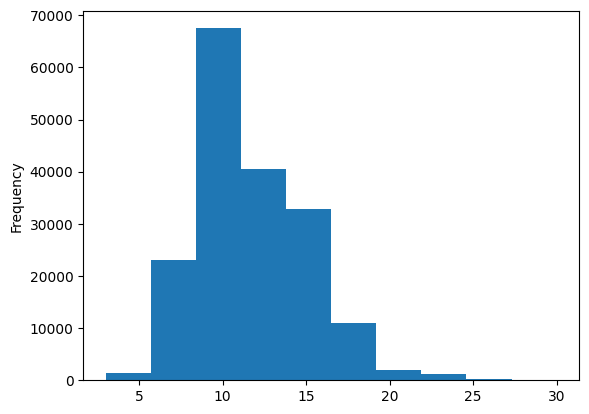

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [ ]:
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_line_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs= y)

combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f76a9521fd0> True
<keras.engine.input_layer.InputLayer object at 0x7f76a95145e0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7f7692dd5a00> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7f76b020ea60> False
<keras.layers.core.embedding.Embedding object at 0x7f76a17e1d60> True
<keras.layers.core.dense.Dense object at 0x7f76a95141c0> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7f76a95e4a30> True
<keras.layers.merging.concatenate.Concatenate object at 0x7f76a945a3d0> True
<keras.engine.input_layer.InputLayer object at 0x7f76a955e160> True
<keras.engine.input_layer.InputLayer object at 0x7f76a94e6550> True
<keras.layers.core.dense.Dense object at 0x7f76a93c7cd0> True
<keras.layers.core.dense.Dense object at 0x7f76a955e520> True
<keras.layers.core.dense.Dense object at 0x7f76a9597220> True
<keras.layers.regularization.dropout.Dropout object at 0x7f76a95a6e20> True
<keras.layers

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer= tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                             val_total_lines_one_hot,
                                                             val_sentences,
                                                             val_chars))

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_pos_char_token_dataset, val_pos_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data = val_pos_char_token_dataset,
                              validation_steps = int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 27s 35ms/step - loss: 1.1075 - accuracy: 0.7140 - val_loss: 0.9867 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9698 - accuracy: 0.8117 - val_loss: 0.9521 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9529 - accuracy: 0.8191 - val_loss: 0.9384 - val_accuracy: 0.8324


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 28s 28ms/step


array([[0.501662  , 0.10463491, 0.01420122, 0.3568034 , 0.02269848],
       [0.55854315, 0.11277194, 0.03919414, 0.2781369 , 0.01135381],
       [0.27375174, 0.10969523, 0.13427247, 0.40661898, 0.07566156],
       ...,
       [0.03528356, 0.11068504, 0.03981167, 0.03287363, 0.7813461 ],
       [0.03298987, 0.29775497, 0.09564376, 0.02367153, 0.5499399 ],
       [0.22522648, 0.5887235 , 0.09029613, 0.03641818, 0.0593357 ]],
      dtype=float32)

In [ ]:
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)
model_5_pred
model_5_pred[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_5_pred)
model_5_results

{'accuracy': 83.22520852641334,
 'precision': 0.830959219519947,
 'recall': 0.8322520852641334,
 'f1': 0.8312295753453135}

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_pos_char_token_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
test_pred_probs = model_5.predict(test_pos_char_token_dataset,
                                  verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 0, 2, 2, 4, 4, 4, 1, 4, 0])>

In [ ]:
all_model_results = pd.DataFrame({"baseline": model_0_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed":model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.667417,0.783705,0.786674,0.784151
pretrained_token_embed,71.266384,0.713111,0.712664,0.709517
custom_char_embed_conv1d,65.659341,0.648666,0.656593,0.644800
hybrid_char_token_embed,73.219251,0.735894,0.732193,0.730274
tribrid_pos_char_token_embed,83.225209,0.830959,0.832252,0.831230


In [ ]:
all_model_results["accuracy"]= all_model_results["accuracy"]/100

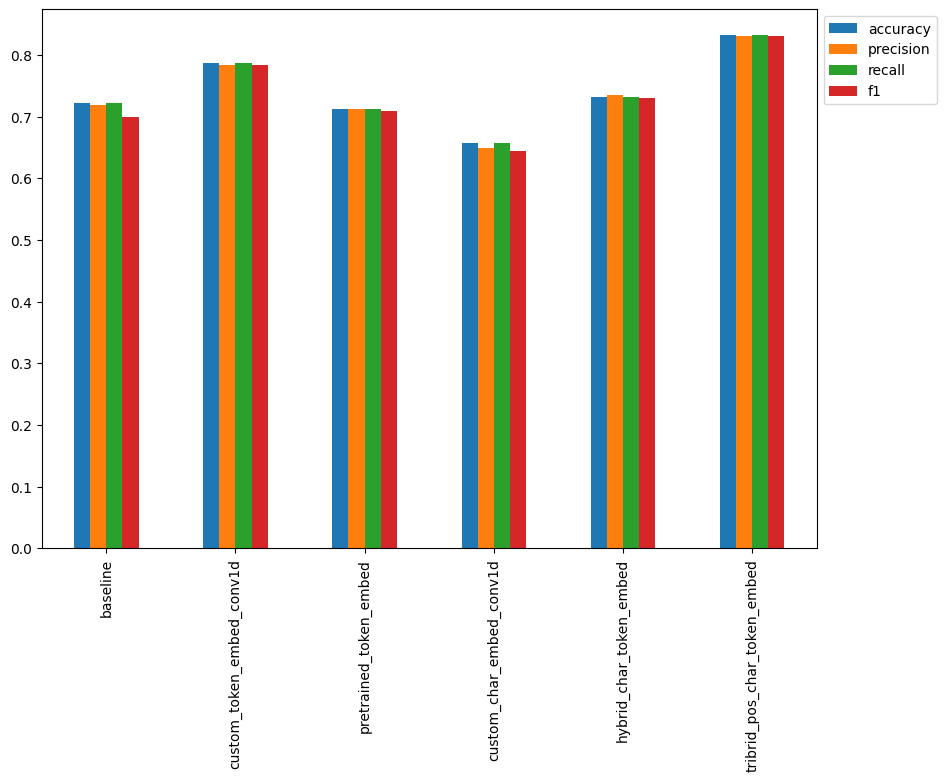

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0));

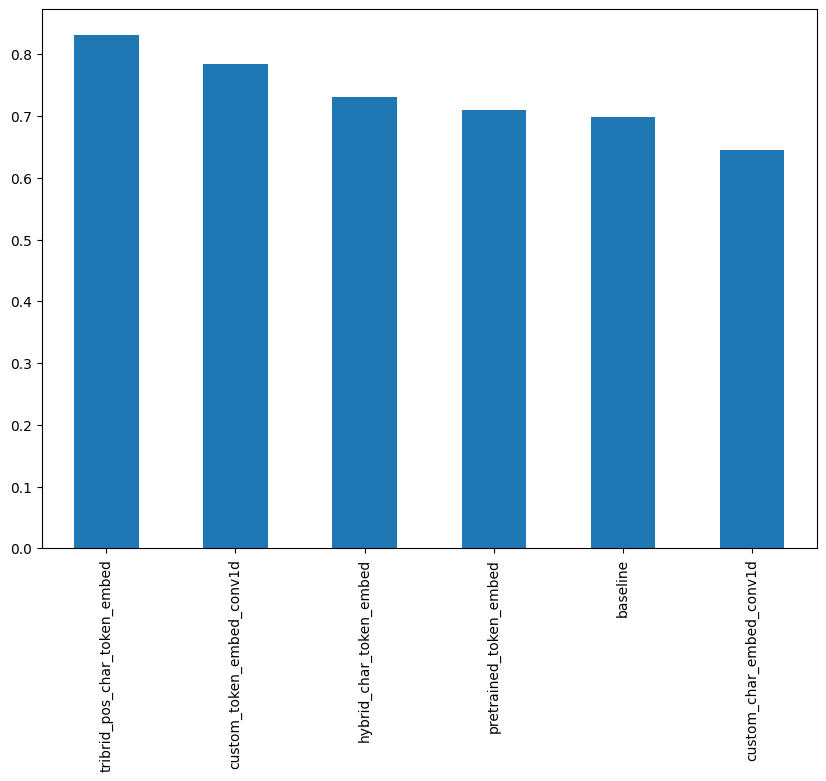

In [ ]:
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10,7));

In [ ]:
model_5.save("skimlit_tribid_model")

In [ ]:
%%time
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

CPU times: user 16.7 s, sys: 845 ms, total: 17.6 s
Wall time: 17.8 s


['OBJECTIVE',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'METHODS',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 

In [ ]:
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy()
test_df["correct"] = test_df["prediction"] == test_df["target"]
test_df.head()

,line_number,target,text,total_lines,prediction,pred_prob,correct
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8,OBJECTIVE,0.457528,False
1,1,RESULTS,a post hoc analysis was conducted with the use...,8,BACKGROUND,0.351795,False
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8,METHODS,0.825418,False
3,3,RESULTS,survival analyses were used to assess the asso...,8,METHODS,0.683376,False
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8,RESULTS,0.661974,True


In [ ]:
top_100_wrong = test_df[test_df["correct"]==False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,line_number,target,text,total_lines,prediction,pred_prob,correct
13874,4,CONCLUSIONS,symptom outcomes will be assessed and estimate...,6,METHODS,0.952460,False
2388,4,RESULTS,the primary endpoint is the cumulative three-y...,13,METHODS,0.945211,False
8545,1,METHODS,pretest-posttest .,11,BACKGROUND,0.941928,False
18720,8,RESULTS,non-diffuse-trickling '' ) .,15,BACKGROUND,0.936457,False
16347,0,BACKGROUND,to evaluate the effects of the lactic acid bac...,12,OBJECTIVE,0.934204,False
...,...,...,...,...,...,...,...
5395,4,RESULTS,diet was supplemented with @ @ ml milk-based f...,12,METHODS,0.840459,False
13860,0,BACKGROUND,to evaluate efficacy and side effects of glyci...,9,OBJECTIVE,0.839807,False
12136,4,RESULTS,"for each individual enrolled as a case , we id...",16,METHODS,0.839212,False
9993,11,METHODS,this study provides class i evidence that in p...,11,CONCLUSIONS,0.839130,False


In [ ]:
for row in top_100_wrong[0:10].itertuples():
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: 4, Pred: METHODS, Prob: 0.9524595141410828, Line number: symptom outcomes will be assessed and estimates of cost-effectiveness made ., Total lines: 6

Text:
CONCLUSIONS

-----

Target: 4, Pred: METHODS, Prob: 0.9452105760574341, Line number: the primary endpoint is the cumulative three-year hiv incidence ., Total lines: 13

Text:
RESULTS

-----

Target: 1, Pred: BACKGROUND, Prob: 0.9419282674789429, Line number: pretest-posttest ., Total lines: 11

Text:
METHODS

-----

Target: 8, Pred: BACKGROUND, Prob: 0.9364572763442993, Line number: non-diffuse-trickling '' ) ., Total lines: 15

Text:
RESULTS

-----

Target: 0, Pred: OBJECTIVE, Prob: 0.9342041611671448, Line number: to evaluate the effects of the lactic acid bacterium lactobacillus salivarius on caries risk factors ., Total lines: 12

Text:
BACKGROUND

-----

Target: 15, Pred: BACKGROUND, Prob: 0.9198809862136841, Line number: -lsb- netherlands trial register ( http://www.trialregister.nl/trialreg/index.asp ) , nr @ , date 